# **Lunar Lander Training - DQN**

### Imports and Setups

In [2]:
import os
import random
import gymnasium as gym
import time
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple, deque
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from itertools import count

print(gym.__version__)
print(torch.__version__)

1.1.1
2.6.0


### GPU Check

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


### Hyperparameters

In [3]:
# Hyperparameters
MAX_EPISODES = 600
ROLLING_WINDOW = 20
MEMORY_SIZE = 10000
MAX_STEPS = 1000

gamma = 0.99
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
learning_rate = 1e-4
batch_size = 128
solved_threshold = 200
TAU = 0.005

### Environment Setup

In [4]:
env = gym.make("LunarLander-v3")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

### Building Training Model

In [7]:
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super().__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

policy_net = DQN(state_size, action_size).to(device)
target_net = DQN(state_size, action_size).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=learning_rate)
criterion = nn.SmoothL1Loss()

### Replay Buffer & Functions

In [8]:
Transition = namedtuple("Transition", ["state", "action", "next_state", "reward", "done"])

class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

replay_buffer = ReplayMemory(MEMORY_SIZE)

def select_action(state):
    global epsilon
    if np.random.rand() < epsilon:
        return torch.tensor([[env.action_space.sample()]], dtype=torch.long, device=device)
    else:
        with torch.no_grad():
            return policy_net(state).max(1).indices.view(1, 1)

### Training Loop

In [9]:
rewards_per_episode = []
rolling_avg_rewards = []

start_time = time.time()

for episode in range(MAX_EPISODES):
    state, _ = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    total_reward = 0

    for t in count():
        action = select_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action.item())

        done = terminated or truncated
        reward_tensor = torch.tensor([reward], device=device)
        next_state_tensor = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)

        replay_buffer.push(state, action, next_state_tensor, reward_tensor, done)
        state = next_state_tensor
        total_reward += reward

        if len(replay_buffer) >= batch_size:
            transitions = replay_buffer.sample(batch_size)
            states, actions, next_states, rewards, dones = zip(*transitions)

            states_batch = torch.cat(states)
            next_states_batch = torch.cat(next_states)
            actions_batch = torch.cat(actions)
            rewards_batch = torch.cat(rewards)
            dones_batch = torch.tensor(dones, device=device)

            q_target = gamma * target_net(next_states_batch).detach().max(1)[0] * ~dones_batch + rewards_batch
            q_policy = policy_net(states_batch).gather(1, actions_batch)

            loss = criterion(q_policy, q_target.unsqueeze(1))

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
            optimizer.step()

            # Soft update target_net
            for target_param, main_param in zip(target_net.parameters(), policy_net.parameters()):
                target_param.data.copy_(TAU * main_param.data + (1.0 - TAU) * target_param.data)

        if done or t >= MAX_STEPS:
            rewards_per_episode.append(total_reward)
            rolling_avg = np.mean(rewards_per_episode[-ROLLING_WINDOW:])
            rolling_avg_rewards.append(rolling_avg)
            print(f"Episode: {episode+1}/{MAX_EPISODES}, Reward: {total_reward:.2f}, "
                  f"Epsilon: {epsilon:.2f}, Rolling Avg: {rolling_avg:.2f}, Steps: {t}")
            break

    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    if rolling_avg >= solved_threshold:
        print(f"Environment solved in {episode+1} episodes!")
        break

end_time = time.time()
print(f"Training completed in {(end_time - start_time)/60:.2f} minutes")

Episode: 1/600, Reward: -128.64, Epsilon: 1.00, Rolling Avg: -128.64, Steps: 77
Episode: 2/600, Reward: -367.31, Epsilon: 0.99, Rolling Avg: -247.98, Steps: 111
Episode: 3/600, Reward: -213.62, Epsilon: 0.99, Rolling Avg: -236.52, Steps: 112
Episode: 4/600, Reward: -422.85, Epsilon: 0.99, Rolling Avg: -283.10, Steps: 75
Episode: 5/600, Reward: -101.26, Epsilon: 0.98, Rolling Avg: -246.74, Steps: 60
Episode: 6/600, Reward: -100.15, Epsilon: 0.98, Rolling Avg: -222.30, Steps: 61
Episode: 7/600, Reward: -116.64, Epsilon: 0.97, Rolling Avg: -207.21, Steps: 100
Episode: 8/600, Reward: -342.72, Epsilon: 0.97, Rolling Avg: -224.15, Steps: 115
Episode: 9/600, Reward: -243.75, Epsilon: 0.96, Rolling Avg: -226.33, Steps: 89
Episode: 10/600, Reward: -264.07, Epsilon: 0.96, Rolling Avg: -230.10, Steps: 65
Episode: 11/600, Reward: -229.90, Epsilon: 0.95, Rolling Avg: -230.08, Steps: 86
Episode: 12/600, Reward: -189.43, Epsilon: 0.95, Rolling Avg: -226.69, Steps: 117
Episode: 13/600, Reward: -465.27

### Plot Rewards

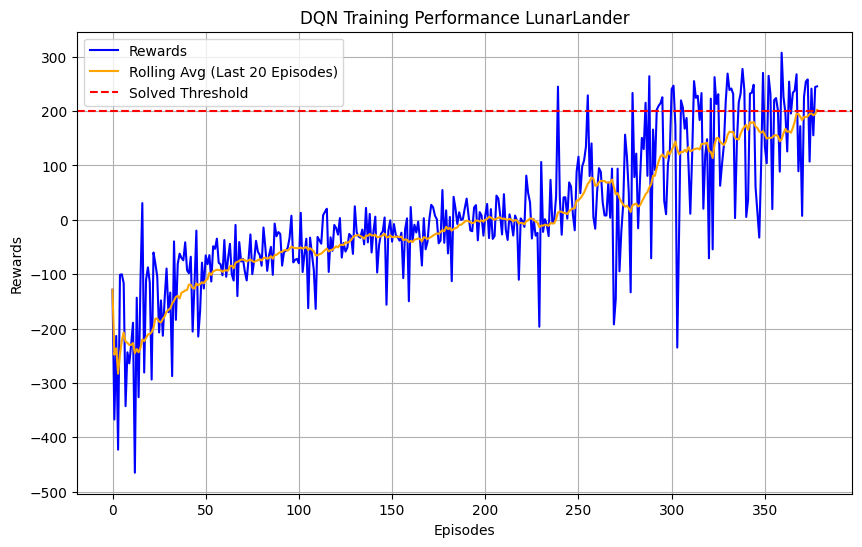

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(rewards_per_episode, label='Rewards', color='blue')
plt.plot(rolling_avg_rewards, label=f'Rolling Avg (Last {ROLLING_WINDOW} Episodes)', color='orange')
plt.axhline(y=solved_threshold, color='red', linestyle='--', label='Solved Threshold')
plt.title('DQN Training Performance LunarLander')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend()
plt.grid()
plt.show()

### Save Model

In [11]:
os.makedirs("models", exist_ok=True)
torch.save(policy_net.state_dict(), "models/dqn_lunarlander.pth")
print("Model saved successfully")

Model saved successfully
